In [1]:
%matplotlib inline
from __future__ import print_function,division
import sys
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

try:
    from importlib import reload # Python 3
except ImportError:
    pass

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import trainimagesource, trainutils, datasource

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'


In [2]:
imwidth = 256
imheight = 256
numimgs = 1000

def createTestImage(width,height,numObjs=12,radMax=30):
    '''Return a noisy 2D image with `numObj' circles and a 2D mask image.'''
    image=np.zeros((width,height))
    
    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x, -y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.random.random()*0.5+0.5
    
    norm=np.random.uniform(0,1.0,size=image.shape)
    
    return np.maximum(image,norm).astype(float),(image>0).astype(float)

def plotPair(im1,im2):
    '''Convenience function for plotting two images side-by-side.'''
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    
dataset=[createTestImage(imwidth,imheight) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]
maskin=np.concatenate([(d[1],) for d in dataset])

394 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
385 ms ± 529 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


1.92 s ± 48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 256, 256, 1) (1000, 256, 256)
3.45 s ± 340 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 256, 256, 1) (1000, 256, 256)


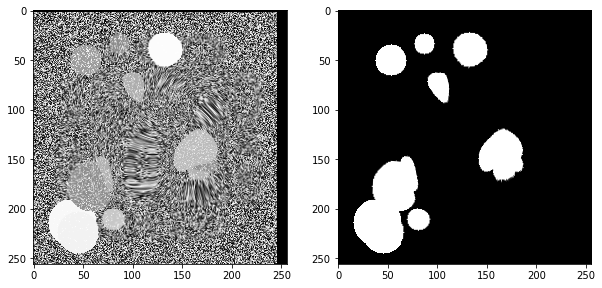

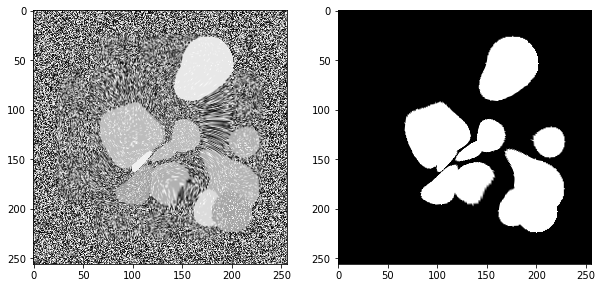

In [7]:
datasource=reload(datasource)
trainimagesource=reload(trainimagesource)

augs=[
    lambda i,m:(i,m.astype(np.float32)),
    trainimagesource.rot90BothAugment, trainimagesource.transposeBothAugment,trainimagesource.flipBothAugment,
    partial(trainimagesource.shiftMaskAugment,dimfract=15,order=0),
    trainimagesource.deformBothAugmentPIL,
]

dsrc=datasource.DataSource(imgin,maskin,augments=augs)

%timeit dsrc.getIndexBatch(np.arange(numimgs))
%timeit dsrc.getRandomBatch(numimgs)

with dsrc.threadBatchGen(numimgs) as gen:
    imgs,masks=gen()
    %timeit gen()

print(imgs.shape,masks.shape)
plotPair(imgs[0,...,0],masks[0])

with dsrc.processBatchGen(numimgs) as gen:
    imgs,masks=gen()
    %timeit gen()

print(imgs.shape,masks.shape)
plotPair(imgs[0,...,0],masks[0])